In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns

np.set_printoptions(suppress=True)

import bayesflow as bf
import tensorflow as tf

from numba import njit

from scipy.stats import halfnorm, maxwell

from functools import partial
from bayesflow.simulation import Prior, Simulator, GenerativeModel

In [7]:
param_names = [r'$r$', r'$v$', r'$\eta$']

def prior_fun(rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
        
    r = maxwell.rvs(2.)
    v = maxwell.rvs(1.)
    eta = halfnorm.rvs(0., 0.1)
    
    return np.array([r, v, eta], dtype=np.float32)

In [8]:
@njit
def initialize_agents(
        num_agents=12,
        boundary_size=10.0,
):

    positions = np.random.random(size=(num_agents, 2)) * boundary_size
    directions = np.random.random(size=num_agents) * np.pi

    return positions, directions

In [9]:
@njit
def simulator_fun(
    theta,
    num_agents=12,
    num_timesteps=100,
    boundary_size=10.0,
):


    radius, speed, eta = theta[0], theta[1], theta[2]

    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents, boundary_size)
    trajectories[0] = positions
    headings[0] = directions[:, np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.mean(np.array(neighbors))
                new_directions[i] = avg_direction + np.random.uniform(-eta, eta)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        
        # Update position upon new direction
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.sin(directions)
        
        # Assumes periodic boundary condition
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = np.copy(positions)
        headings[t + 1] = np.copy(directions[:, np.newaxis])

    return np.concatenate((trajectories, headings), axis=-1)

# Generative Model

In [10]:
prior = Prior(prior_fun=prior_fun)

simulator = Simulator(simulator_fun=simulator_fun)

model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Vicsek V2")

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'maxwell':[0m [1m[1mCannot determine Numba type of <class 'scipy.stats._continuous_distns.maxwell_gen'>[0m
[1m
File "..\..\..\..\..\AppData\Local\Temp\ipykernel_16160\819211749.py", line 6:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

# Configurator

In [6]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

In [138]:
# class StackedLSTM(tf.keras.Model):
#     def __init__(self, summary_dim=32, lstm_units=512, hidden_units=512, dropout=0.05):
#         super().__init__()
        
#         self.mlp = tf.keras.Sequential([
#             tf.keras.layers.Dense(hidden_units, activation="mish"),
#             tf.keras.layers.Dropout(dropout),
#             tf.keras.layers.Dense(hidden_units // 16)
#         ])
#         self.lstm = tf.keras.layers.LSTM(lstm_units, dropout=dropout)
#         self.projector = tf.keras.layers.Dense(summary_dim)
        
#     def call(self, x, **kwargs):
        
#         old_shape = tf.shape(x)
#         x = tf.reshape(x, shape=(old_shape[0], old_shape[1], -1))
#         embeddings = self.mlp(x, **kwargs)
#         rep = self.lstm(embeddings, **kwargs)
#         proj = self.projector(rep)
#         return proj

# Neural Approximator

In [25]:
# # This one generalizes over different numbers of agents
# summary_net = bf.summary_networks.HierarchicalNetwork([
#     tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM()),
#     bf.networks.SetTransformer(num_inducing_points=None, input_dim=32)
# ])

In [20]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=5,
    coupling_design="affine",
    coupling_settings={
        'kernel_regularizer': None,
        'dropout_prob': 0.0
    }
)


amortizer = bf.amortizers.AmortizedPosterior(
    summary_net=summary_net, 
    inference_net=inference_net
)


trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training

In [21]:
mini_history = trainer.train_online(epochs=50, batch_size=32, iterations_per_epoch=500)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/500 [00:00<?, ?it/s]

# Validation

In [22]:
validation_sim = model(300)
validation_configured = configurator(validation_sim)

In [23]:
post_samples = amortizer.sample(validation_configured, n_samples=1000)
prior_samples = validation_configured["parameters"]

# Parameter Recovery

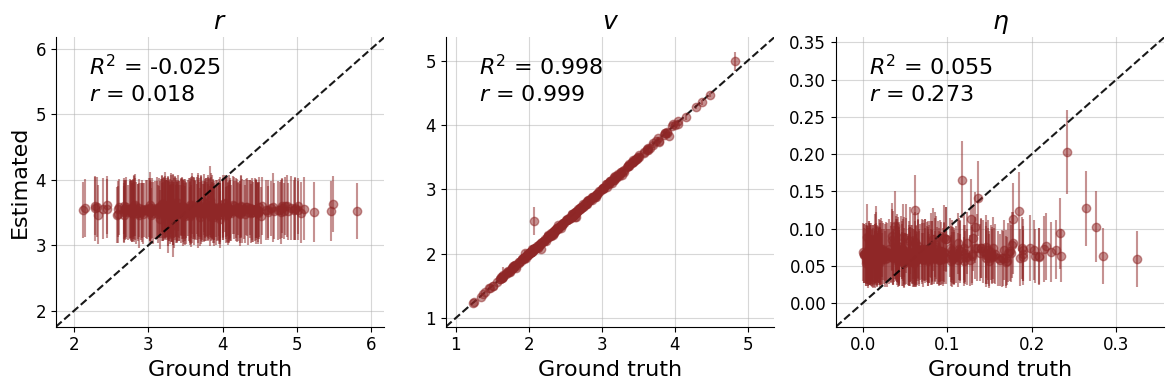

In [24]:
g = bf.diagnostics.plot_recovery(
    post_samples=post_samples, 
    prior_samples=prior_samples, 
    param_names=param_names
)

The drift $v$ shows near-perfect recovery, followed by the noise parameter $\eta$.

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


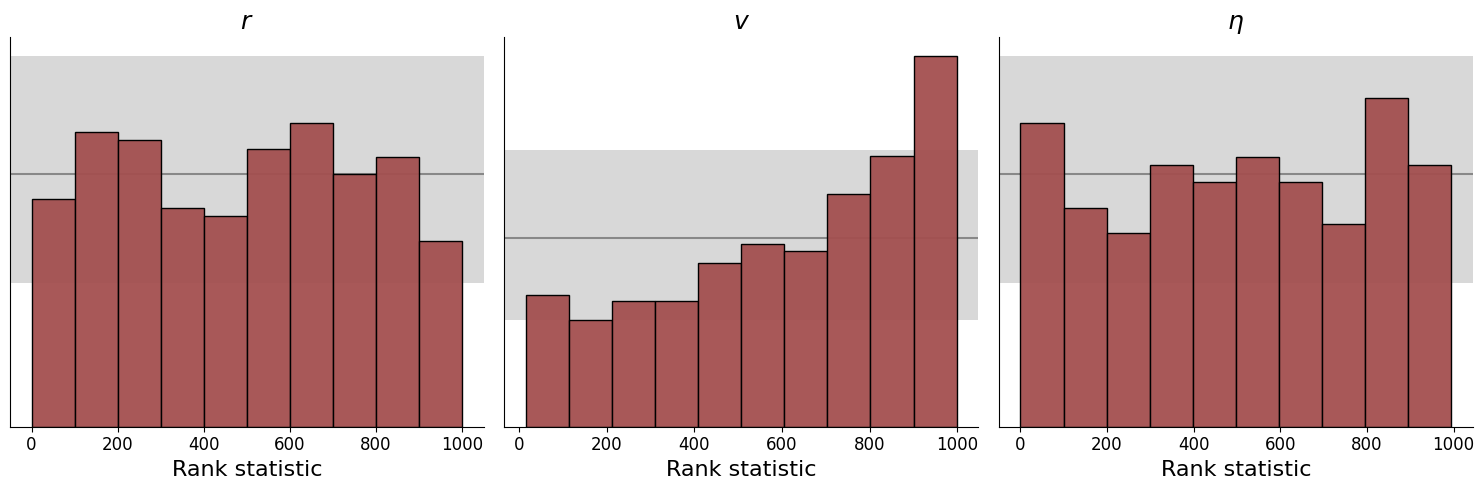

In [15]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

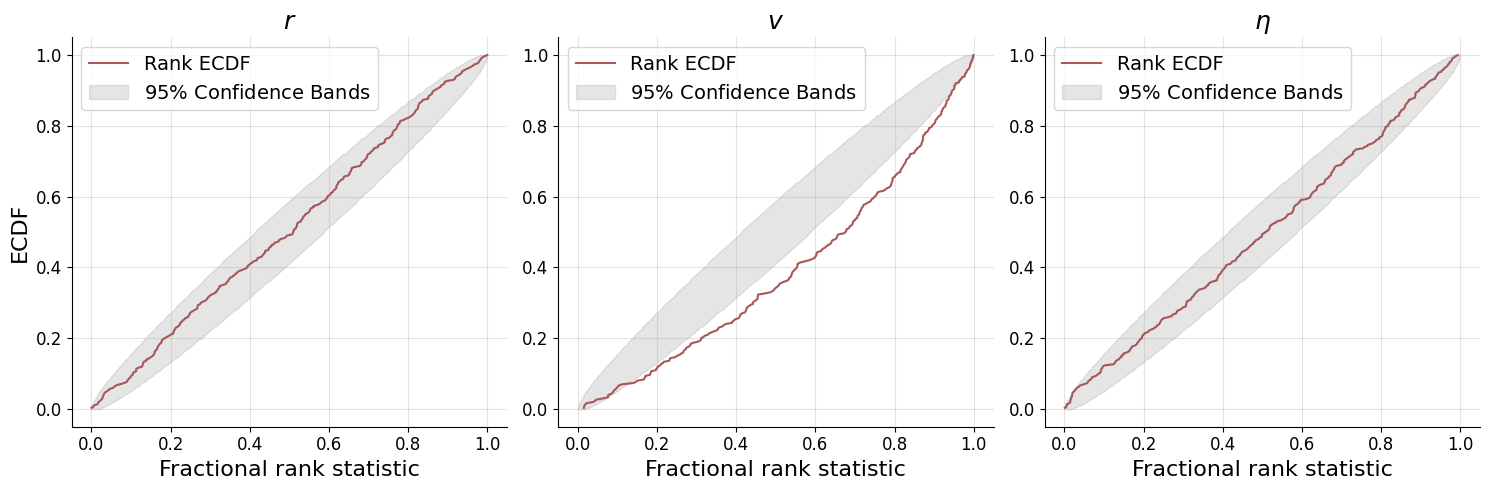

In [16]:
e = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

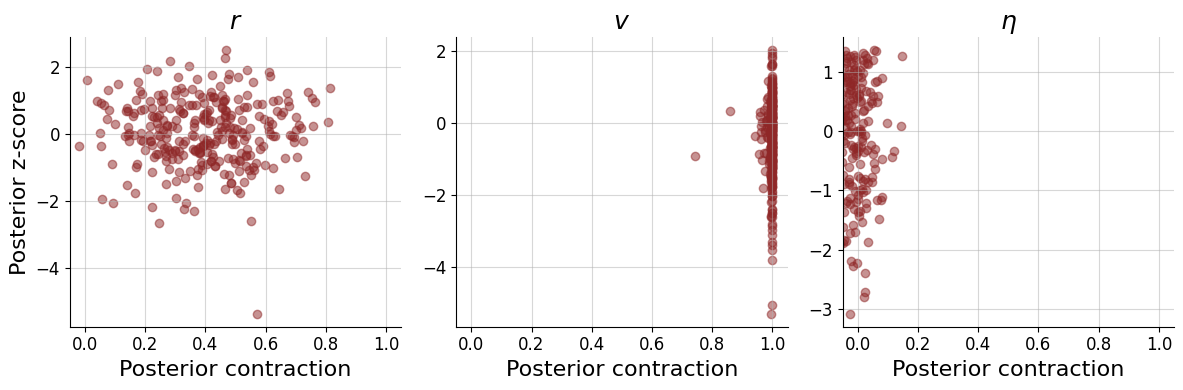

In [17]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)